# 最终版run_model
# final version of run_model


In [3]:
# import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import utils

In [4]:
# Load data
data_arr = utils.load_data(
    "../data/arrays", mask=False
)

Loading variables: ['ndvi', 'sm_30cm_mean', 'RAIN_sum', 'irrig_mm_sum', 'IRRAD_sum', 'TMIN_mean', 'TMAX_mean', 'VAP_mean', 'WIND_mean']
ndvi stats:
 - Mean: 0.6202584
 - Std: 0.2126209
 - Min: 0.30207366
 - Max: 0.95584416
sm_30cm_mean stats:
 - Mean: 25.592056
 - Std: 1.9488047
 - Min: 22.266981
 - Max: 28.896538
RAIN_sum stats:
 - Mean: 6.2400007
 - Std: 10.17536
 - Min: 0.0
 - Max: 43.43
irrig_mm_sum stats:
 - Mean: 2.6147704
 - Std: 7.5484
 - Min: 0.0
 - Max: 30.0
IRRAD_sum stats:
 - Mean: 61729.73
 - Std: 14279.029
 - Min: 13110.0
 - Max: 86300.0
TMIN_mean stats:
 - Mean: 12.134594
 - Std: 2.9194298
 - Min: 5.23
 - Max: 17.506666
TMAX_mean stats:
 - Mean: 24.711082
 - Std: 3.9099383
 - Min: 17.663334
 - Max: 34.386665
VAP_mean stats:
 - Mean: 1.4465002
 - Std: 0.28246108
 - Min: 0.88630325
 - Max: 2.046529
WIND_mean stats:
 - Mean: 7.1424327
 - Std: 1.8819456
 - Min: 3.6966667
 - Max: 11.446667
Data loaded with shape: (37, 49, 76, 9)


## 划分训练集，验证集和测试集
## Divide the dataset into training, validation, and test sets.
可以看到时间步一共是37步，在划分数据集的时候有一个要点，就是模型输入的是一段连续序列，输出则是将输入序列时间步往后平移一步的连续序列。我们以test集为例：test的输入是t0,t1...t5六个时间步，那输出则是t1,t2...t6。所以划分的时候一定要在输入的基础上+1。这里我划分为- test: 6 steps 7 个时间点- train: 21 steps  22 个时间点（放中间）- val: 7 steps 8 个时间点。

另外一个重要点，在训练数据不够的情况下（例如仅有一段植物生长和衰弱），一定要将训练集覆盖住植被生长和衰弱两段不同时期，这样模型能训练到这两段不同趋势。在run_model_origin中能看到反例。

There are a total of 37 time steps. A key point when partitioning the dataset is that the model input is a continuous sequence, and the output is a continuous sequence with the input time steps shifted one step forward. Taking the test set as an example: the input to the test set is six time steps t0, t1...t5, so the output is t1, t2...t6. Therefore, the partition must be one step greater than the input. Here, I partitioned it as follows: - test: 6 steps (7 time points) - train: 21 steps (22 time points, placed in the middle) - val: 7 steps (8 time points).

Another important point is that when there is insufficient training data (e.g., only one period of plant growth and decline), the training set must cover both growth and decline periods so that the model can be trained to capture these two different trends. A counterexample can be seen in `run_model_origin`.

In [5]:
import numpy as np

def _normalize_array(arr, mean, std):
    return (arr - mean) / (std + 1e-8)

def split_37_midtrain_21_6_7(inputs_all, outputs_all, total_steps=37):
    """
    总时间点 = 37
    切分按“相邻预测 (t -> t+1)”的 input-step 数量：
      - test: 6 steps  -> 需要 7 个时间点
      - train: 21 steps -> 需要 22 个时间点（放中间）
      - val: 7 steps -> 需要 8 个时间点
    7 + 22 + 8 = 37（完全用满，且互不重叠）
    """

    T = inputs_all.shape[0]
    assert T >= total_steps, f"inputs_all 时间步不足：T={T}, 需要 >= {total_steps}"

    inputs_all = inputs_all[:total_steps]
    outputs_all = outputs_all[:total_steps]

    # outputs 统一成 (T, x, y, 1)
    if outputs_all.ndim == 3:
        outputs_all_4d = np.expand_dims(outputs_all, axis=-1)
    elif outputs_all.ndim == 4 and outputs_all.shape[-1] == 1:
        outputs_all_4d = outputs_all
    else:
        raise ValueError(f"outputs_all 维度不符合预期: {outputs_all.shape}")

    # ========= 时间点分配（不重叠）=========
    # test : timepoints [0..6]   (7点)  -> steps=6
    # train: timepoints [7..28]  (22点) -> steps=21  (中间段)
    # val : timepoints [29..36] (8点)  -> steps=7
    test_tp_start,  test_tp_end  = 0, 6
    train_tp_start, train_tp_end = 7, 28
    val_tp_start,   val_tp_end   = 29, 36

    # ========= 训练归一化统计量：只用训练段 inputs（21 steps 对应的 inputs）=========
    # 训练 inputs 使用 timepoints [7..27]（21步）
    train_inputs_raw = inputs_all[train_tp_start : train_tp_end]  # 7..27 (21, x, y, C)
    stats_arr = train_inputs_raw.reshape(-1, train_inputs_raw.shape[-1])
    mean = np.nanmean(stats_arr, axis=0)
    std  = np.nanstd(stats_arr, axis=0)

    # ========= 构造 (inputs_steps, outputs_steps) =========
    inputs_val  = _normalize_array(inputs_all[val_tp_start : val_tp_end], mean, std)           # (7, x, y, C)
    outputs_val = outputs_all_4d[val_tp_start + 1 : val_tp_end + 1]                            # (7, x, y, 1)

    inputs_train  = _normalize_array(inputs_all[train_tp_start : train_tp_end], mean, std)     # (21, x, y, C)
    outputs_train = outputs_all_4d[train_tp_start + 1 : train_tp_end + 1]                       # (21, x, y, 1)

    inputs_test  = _normalize_array(inputs_all[test_tp_start : test_tp_end], mean, std)        # (6, x, y, C)
    outputs_test = outputs_all_4d[test_tp_start + 1 : test_tp_end + 1]                          # (6, x, y, 1)

    print("=== Split (total=37, train=middle) ===")
    print("VAL  timepoints:", (val_tp_start, val_tp_end), "steps:", inputs_val.shape[0])
    print("TRAIN timepoints:", (train_tp_start, train_tp_end), "steps:", inputs_train.shape[0])
    print("TEST timepoints:", (test_tp_start, test_tp_end), "steps:", inputs_test.shape[0])
    print("shapes:")
    print("  inputs_train :", inputs_train.shape, "outputs_train:", outputs_train.shape)
    print("  inputs_val   :", inputs_val.shape,   "outputs_val  :", outputs_val.shape)
    print("  inputs_test  :", inputs_test.shape,  "outputs_test :", outputs_test.shape)

    return inputs_train, outputs_train, inputs_val, outputs_val, inputs_test, outputs_test, mean, std



In [6]:
inputs_all = data_arr  # 输入数据包含所有通道
outputs_all = data_arr[:, :, :, 0]  # 输出数据仅包含第一个通道（NDVI）

inputs_train, outputs_train, inputs_val, outputs_val, inputs_test, outputs_test, mean, std = \
    split_37_midtrain_21_6_7(inputs_all, outputs_all, total_steps=37)

=== Split (total=37, train=middle) ===
VAL  timepoints: (29, 36) steps: 7
TRAIN timepoints: (7, 28) steps: 21
TEST timepoints: (0, 6) steps: 6
shapes:
  inputs_train : (21, 49, 76, 9) outputs_train: (21, 49, 76, 1)
  inputs_val   : (7, 49, 76, 9) outputs_val  : (7, 49, 76, 1)
  inputs_test  : (6, 49, 76, 9) outputs_test : (6, 49, 76, 1)


## 搭建模型
## build model

In [ ]:
model = utils.build_model(inputs_train)

lr = 2e-4  # 从 0.002 降到 0.0002

try:
    # TF 2.11+ 通常有 AdamW
    opt = keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
except:
    opt = keras.optimizers.Adam(learning_rate=lr)
    
model.compile(
    loss="mean_squared_error",   # 使用均方误差作为损失函数
    optimizer=opt,   # 使用Adam优化器，学习率
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 49, 76,   │             0 │
│                                 │ 9)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, None, 49, 76,   │        47,360 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, None, 49, 76,   │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, None, 49, 76,   │         1,729 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,529 (1.03 MB)

 Trainable params: 270,529 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## 训练模型
## Train model

In [ ]:
# Callbacks
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)   # 验证集 loss 连续 10 个 epoch 不变好就停止训练
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,              # 让它多看一会
    min_delta=1e-4,           # 小于这个改善不算改善，避免抖动骗停
    restore_best_weights=True # 非常关键：停的时候回到最好的那一轮
)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)   # 验证集 loss 连续 5 个 epoch 不变好就降低学习率
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)
callbacks = [early_stopping, reduce_lr]

# Epochs
epochs = 100

# Fit the model
training_data = model.fit(
    np.expand_dims(inputs_train, 0),
    np.expand_dims(outputs_train, 0),
    epochs=epochs,
    batch_size=1,
    validation_data=(np.expand_dims(inputs_val, 0), np.expand_dims(outputs_val, 0)),
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0920 - val_loss: 0.0547 - learning_rate: 2.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - loss: 0.0819 - val_loss: 0.0526 - learning_rate: 2.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step - loss: 0.0735 - val_loss: 0.0507 - learning_rate: 2.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step - loss: 0.0667 - val_loss: 0.0489 - learning_rate: 2.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - loss: 0.0609 - val_loss: 0.0472 - learning_rate: 2.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step - loss: 0.0563 - val_loss: 0.0458 - learning_rate: 2.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step - loss: 0.0528 - val_loss: 0.0445 - learning_rate: 2.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step - loss: 0.0497 - val_loss: 0.0434 - learning_rate: 2.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step - loss: 0.0467 - val_loss: 0.0426 - learning_rat

## 画loss曲线

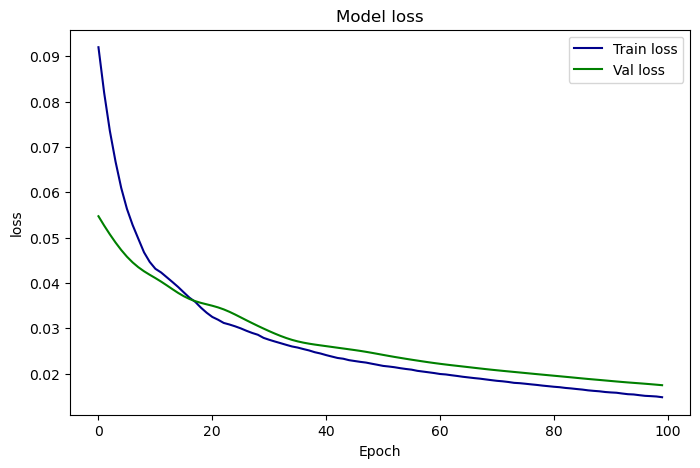

In [ ]:
metrics = ["loss"]   # 画 loss 曲线

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(training_data.history[metric], c="darkblue", label=f"Train {metric}")
    plt.plot(training_data.history[f"val_{metric}"], c="green", label=f"Val {metric}")

    plt.title(f"Model {metric}")
    plt.ylabel(metric)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

## 对test集做预测

In [ ]:
score = model.evaluate(  # 对 test 集做一次 loss 评估
    np.expand_dims(inputs_test, 0),
    np.expand_dims(outputs_test, 0),
    batch_size=1,
)
predictions = model.predict(np.expand_dims(inputs_test, 0))    # 对 test 集做预测
np.save("test_arrays", predictions)
print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - loss: 0.0244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
0.024441756308078766


可视化真实ndvi和预测ndvi

Visualizing real ndvi and predicted ndvi

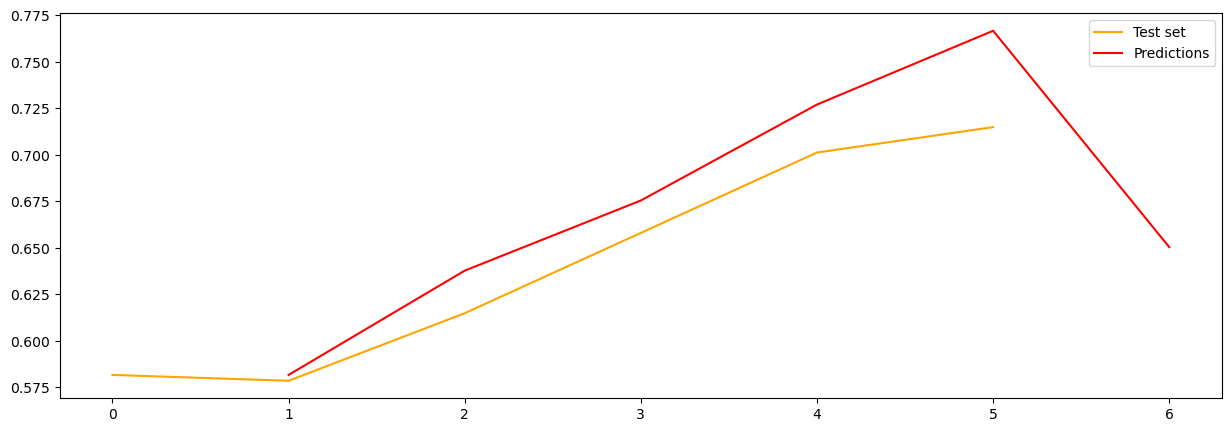

In [ ]:
# 把整张 NDVI 图压缩成时间序列再画图
fig, ax = plt.subplots(figsize=(15, 5))

existing_y = np.nanmean(
    np.reshape(
        outputs_test,
        (outputs_test.shape[0], outputs_test.shape[1] * outputs_test.shape[2]),
    ),
    axis=1,
)
existing_x = np.array(range(len(existing_y)))
later_x = existing_x + 1
found_y = np.nanmean(
    np.reshape(
        predictions[0],
        (predictions.shape[1], predictions.shape[2] * predictions.shape[3]),
    ),
    axis=1,
)

plt.plot(existing_x, existing_y, c="orange", label="Test set")
plt.plot(later_x, found_y, c="red", label="Predictions")
plt.legend()
plt.show()

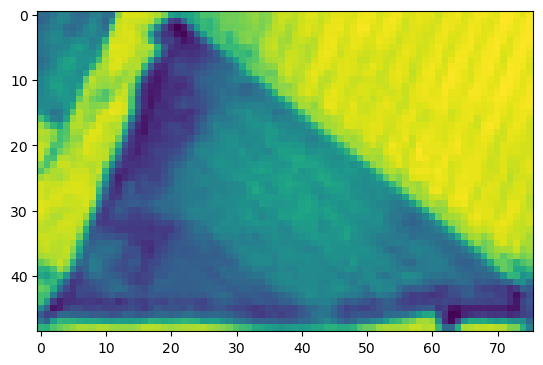

In [ ]:
# Last NDVI timestep before the prediction
plt.imshow(outputs_test[-1, :, :, 0])   # 取 test 集最后一个时间步的真实 NDVI 图

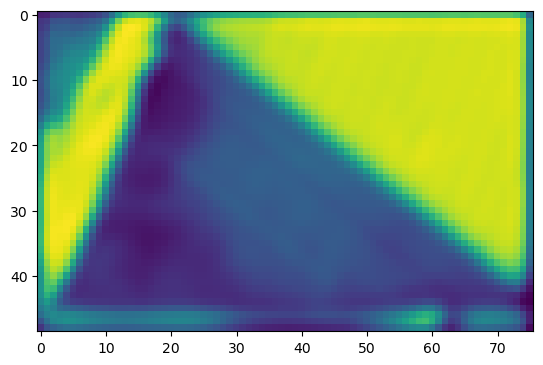

In [ ]:
# Prediction
plt.imshow(predictions[0, -1, :, :, 0])